# Commodity basis momentum

In this notebook, we try to replicate the basis momentum effect studied in Boons 2019. They found that the basis momentum (spread between momentum in the 1st contract and the one in 2nd contract) predicts the cross-sectional return of commodity returns.

In [1]:
from datetime import datetime
from itertools import product
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest.analytics import rebase
from vivace.backtest.contract import all_futures_boons2019, InstrumentDef
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance
from vivace.enums import Strategy

# Data

We look at the following 27 commodity futures. Note that this set is slightly smaller than the one in the original paper. Some commodities are removed due to data availability.

In [2]:
all_futures_boons2019

,name
ticker,
CL,WTI Crude Oil
CO,Brent Crude Oil
HO,Heating Oil
NG,Natural Gas
QS,Gas Oil
RR,Rough Rice
SB,Sugar
C,Corn
ZO,Oats


# Performance

## Outright returns

The basis momentum is a cross-sectional strategy where every month commodities with highest basis momentum are bought and ones with lowest are sold. Concretely, the basis momentum signal is defined as the follows:

$$
BM_t = \Pi_{s=t-11}^t \left(1 + R_{fut, s}^{T_1}\right) - \Pi_{s=t-11}^t \left(1 + R_{fut, s}^{T_2}\right)
$$

where
- $R_{fut, s}^{T_1}$ is the monthly return of the 1st futures contract
- $R_{fut, s}^{T_2}$ is the monthly return of the 2nd futures contract

Once commodities are selected, those positions are maintained for the remainder of the month. Each commodity is weighted by equal dollar notional.

In [3]:
engine_outright = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_boons2019.index,
    signal=signal.XSBasisMomentum(),
    log_level=logging.WARN,
)
engine_outright.run()

In [4]:
outright_return = (engine_outright.calculate_equity_curve(calculate_net=False)
                   .rename('Commodity basis momentum (outright)'))

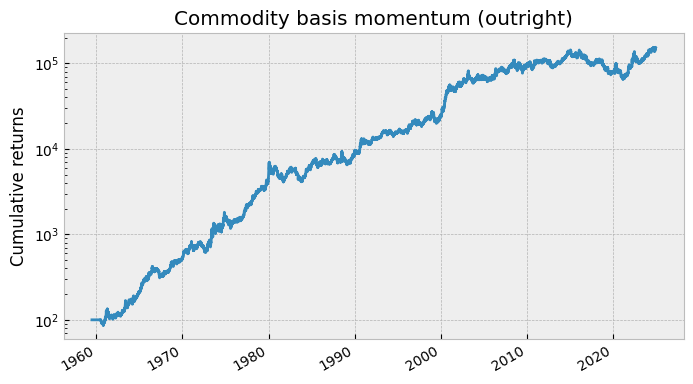

In [5]:
fig, ax = plt.subplots(figsize=(8, 4.5))
outright_return.plot(ax=ax, logy=True);
ax.set_title('Commodity basis momentum (outright)')
ax.set_ylabel('Cumulative returns');

In [6]:
outright_return.pipe(Performance).summary()

,Commodity basis momentum (outright)
CAGR,0.110226
Annualised vol,0.180857
Sharpe ratio,0.609467
Max drawdown,0.545770
Calmar ratio,0.201965
Skewness,-0.096460
Kurtosis,3.024458
Worst return,-0.114312
Worst 1d return,-0.114312
Worst 1w return,-0.165338


## Spread returns

Similar to the outright basis momentum strategy mentioned above, each commodity is selected based on $BM_t$. However in this case we enter a spread position (long 1st and short 2nd) for commodities with the highest basis momentum signal, and sell a spread position (short 1st and long 2nd) for ones with the lowest signal.

In [7]:
engine_spread = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=[InstrumentDef(i, nth_expiry=j, id=f'{i}_{j}') for i, j in product(all_futures_boons2019.index, [1, 2])],
    signal=signal.XSBasisMomentumSpread(
        signal_def={i: (f'{i}_1', f'{i}_2') for i in all_futures_boons2019.index},
        instr_to_signal={f'{i}_{j}': (f'{i}', True if j == 1 else False) for i, j in product(all_futures_boons2019.index, [1, 2])},
    ),
    log_level=logging.WARN,
)
engine_spread.run()

In [8]:
spread_return = (engine_spread.calculate_equity_curve(calculate_net=False)
                 .rename('Commodity basis momentum (spread)'))

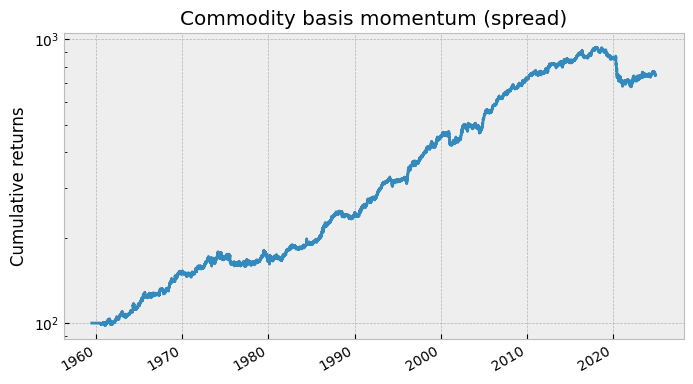

In [9]:
fig, ax = plt.subplots(figsize=(8, 4.5))
spread_return.plot(ax=ax, logy=True);
ax.set_title('Commodity basis momentum (spread)')
ax.set_ylabel('Cumulative returns');

In [10]:
spread_return.pipe(Performance).summary()

,Commodity basis momentum (spread)
CAGR,0.030157
Annualised vol,0.050736
Sharpe ratio,0.594388
Max drawdown,0.274637
Calmar ratio,0.109806
Skewness,0.172221
Kurtosis,7.967050
Worst return,-0.029928
Worst 1d return,-0.029928
Worst 1w return,-0.041919


# Post publication

In [11]:
portfolio_return = pd.concat((
    outright_return,
    spread_return
), axis=1)

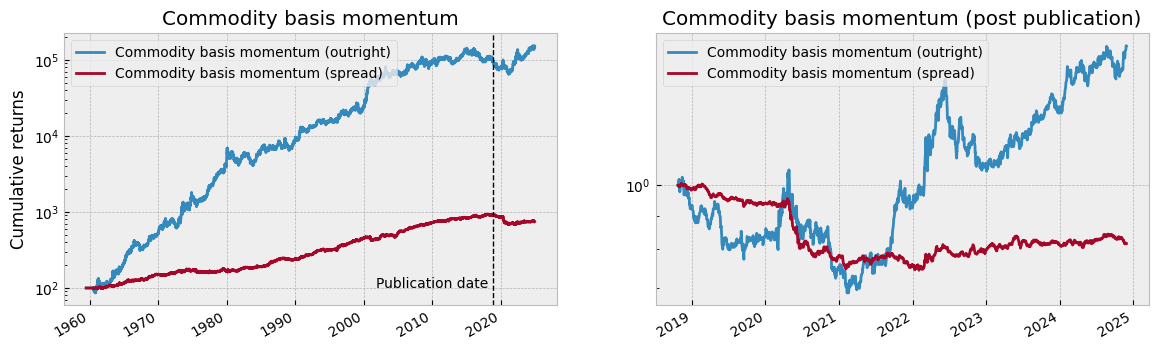

In [12]:
publication_date = datetime(2018, 10, 24)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
portfolio_return.plot(ax=ax[0], logy=True);
ax[0].set_title('Commodity basis momentum')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

portfolio_return.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Commodity basis momentum (post publication)');

The authors used data up to Feb-2014. Since then both portfolios suffered for a while although more recently in 2020s they are coming back.

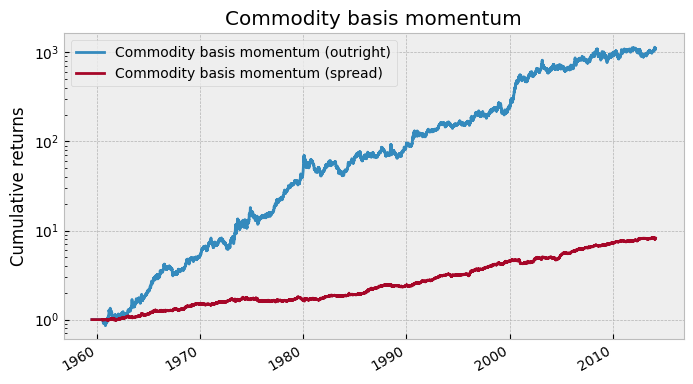

In [13]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return[:'2014-02'].pipe(rebase).plot(ax=ax, logy=True);
ax.set_title('Commodity basis momentum')
ax.set_ylabel('Cumulative returns');

# Recent performance

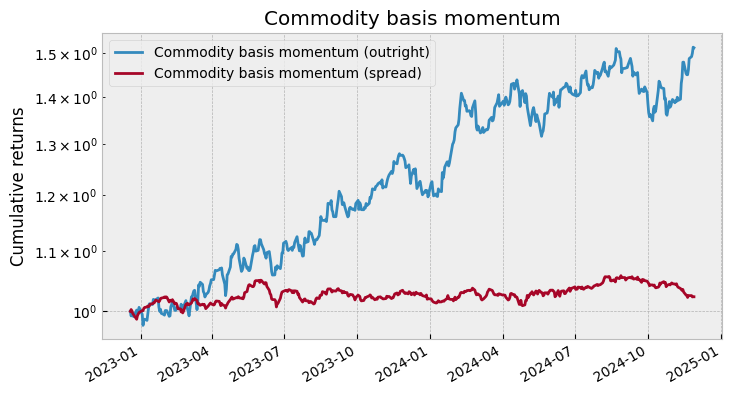

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True);
ax.set_title('Commodity basis momentum')
ax.set_ylabel('Cumulative returns');

# Reference

- Boons, M. and Prado, M.P., 2019. Basis‐momentum. _The Journal of Finance_, _74_(1), pp.239-279.

In [15]:
print(f'Updated: {datetime.now(pytz.utc).strftime("%d-%b-%Y %H:%M")}')

Updated: 29-Nov-2024 08:51
